In [1]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
`Quickstart <quickstart_tutorial.html>`_ ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
**Build Model** ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Build the Neural Network
===================

Neural networks comprise of layers/modules that perform operations on data.
The `torch.nn <https://pytorch.org/docs/stable/nn.html>`_ namespace provides all the building blocks you need to
build your own neural network. Every module in PyTorch subclasses the `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_.
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training
-----------------------
We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
`torch.cuda <https://pytorch.org/docs/stable/notes/cuda.html>`_ is available, else we
continue to use the CPU.



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Define the Class
-------------------------
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.

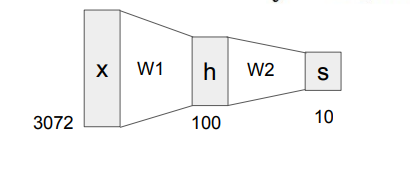

In [ ]:
class NeuralNetwork(nn.Module): #nn.Module이라 forward
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() #28*28를 1차원으로 펴주는 역할 1*784 
        #computational graphs
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #weight matrix :  784*512
            nn.ReLU(),
            nn.Linear(512, 512), #weight matrix : 512*512
            nn.ReLU(),
            nn.Linear(512, 10),  #weight matrix : 512*10
        )

    def forward(self, x): #입력을 받아 predict
        x = self.flatten(x)
        logits = self.linear_relu_stack(x) #logit 1* 10차원
        
        return logits

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.



In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model's ``forward``,
along with some `background operations <https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866>`_.
Do not call ``model.forward()`` directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class.
We get the prediction probabilities by passing it through an instance of the ``nn.Softmax`` module.



In [ ]:
X = torch.rand(1, 28, 28, device=device) #28*28 이미지 선언
logits = model(X) #모델의 출력값
pred_probab = nn.Softmax(dim=1)(logits) #10차원 벡터에 softmax 함수 적용 -> 결과값을 확률로 변환(score)
y_pred = pred_probab.argmax(1) #확률 값 중 가장 큰 값을 가진 인덱스를 출력
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8], device='cuda:0')


--------------




In [ ]:
logits

tensor([[ 0.0095,  0.0111, -0.0064,  0.0016, -0.0133,  0.0151, -0.0302, -0.0306,
          0.1354, -0.0027]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_probab

tensor([[0.0999, 0.1001, 0.0984, 0.0992, 0.0977, 0.1005, 0.0961, 0.0960, 0.1134,
         0.0987]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
y_pred

tensor([8], device='cuda:0')

Model Layers
-------------------------

Let's break down the layers in the FashionMNIST model. To illustrate it, we
will take a sample minibatch of 3 images of size 28x28 and see what happens to it as
we pass it through the network.

파라미터 개수 : sum(w1,w2, w3의 크기)784 * 512 + 512 * 512 + 512 * 10


In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


nn.Flatten
^^^^^^^^^^^^^^^^^^^^^^
We initialize the `nn.Flatten  <https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html>`_
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (
the minibatch dimension (at dim=0) is maintained).



In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


nn.Linear
^^^^^^^^^^^^^^^^^^^^^^
The `linear layer <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>`_
is a module that applies a linear transformation on the input using its stored weights and biases.




In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


nn.ReLU
^^^^^^^^^^^^^^^^^^^^^^
Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use `nn.ReLU <https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html>`_ between our
linear layers, but there's other activations to introduce non-linearity in your model.



In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.2955,  0.5335, -0.0652,  0.1651,  0.8874, -0.0698,  0.2496, -0.5322,
          0.1691, -0.5692, -0.2165, -0.0991, -0.2621,  0.2609,  0.4795, -0.1790,
          0.1262,  0.1799,  0.1691, -0.0200],
        [ 0.2643,  0.2345,  0.0506,  0.4760,  0.5401, -0.0383,  0.6186, -0.3384,
          0.4997, -0.6219, -0.0446, -0.3388, -0.1687,  0.0765,  0.0973,  0.2120,
         -0.0048,  0.3700, -0.0511,  0.2326],
        [ 0.3637,  0.5706,  0.3383,  0.5027,  0.5356,  0.1173,  0.3804, -0.2464,
          0.8495, -0.6870,  0.1958,  0.0388, -0.1753, -0.0980,  0.2666,  0.0621,
          0.0187,  0.5568, -0.0382,  0.0048]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.2955, 0.5335, 0.0000, 0.1651, 0.8874, 0.0000, 0.2496, 0.0000, 0.1691,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2609, 0.4795, 0.0000, 0.1262, 0.1799,
         0.1691, 0.0000],
        [0.2643, 0.2345, 0.0506, 0.4760, 0.5401, 0.0000, 0.6186, 0.0000, 0.4997,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0765, 0.09

nn.Sequential
^^^^^^^^^^^^^^^^^^^^^^
`nn.Sequential <https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>`_ is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.



In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

nn.Softmax
^^^^^^^^^^^^^^^^^^^^^^
The last linear layer of the neural network returns `logits` - raw values in [-\infty, \infty] - which are passed to the
`nn.Softmax <https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html>`_ module. The logits are scaled to values
[0, 1] representing the model's predicted probabilities for each class. ``dim`` parameter indicates the dimension along
which the values must sum to 1.



In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits) #[0,1]사이로 결과 스케일링

Model Parameters
-------------------------
Many layers inside a neural network are *parameterized*, i.e. have associated weights
and biases that are optimized during training. Subclassing ``nn.Module`` automatically
tracks all fields defined inside your model object, and makes all parameters
accessible using your model's ``parameters()`` or ``named_parameters()`` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.




In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0029, -0.0239, -0.0169,  ...,  0.0168,  0.0103,  0.0101],
        [-0.0030, -0.0216, -0.0185,  ..., -0.0161,  0.0159, -0.0323]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0149,  0.0292], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0018, -0.0001,  0.0343,  ..., -0.0200, -0.0029, -0.0122],
        [ 0.0092, -0.0028,  0.0338,  ..., -0.0003,  0.0221,  0.0203]],
       device='cuda:0', grad_fn=<Sl

--------------




Further Reading
--------------
- `torch.nn API <https://pytorch.org/docs/stable/nn.html>`_

